In [1]:
import numpy as np
import nibabel as nib                                                     
#import itk                                                                
#import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate # Using Basic Image agumentation techniques will receive Fake Images 
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
%matplotlib inline
import seaborn as sns

import os
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

In [3]:
import segmentation_models as sm
import tensorflow as tf
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet, PSPNet, FPN
import keras
from segmentation_models.utils import set_trainable
from torch.utils.data import Dataset
from keras.models import load_model
from tensorflow.keras import utils as np_utils
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

(240, 256, 512)
(240, 256, 512)
(240, 256, 512)
(240, 256, 512)
(240, 256, 512)


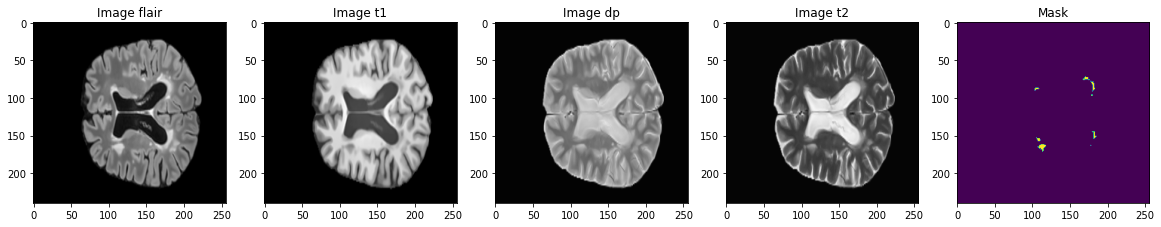

In [4]:
TRAIN_DATASET_PATH = r'E:/sclerosis dataset/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_T1_preprocessed.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_T2_preprocessed.nii').get_fdata()
test_image_dp=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_DP_preprocessed.nii').get_fdata()
test_image_Brain_Mask=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_Consensus.nii').get_fdata()
    

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w =280
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_dp[:,:,test_image_dp.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image dp')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_image_Brain_Mask[:,:,test_image_Brain_Mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

print(test_image_flair.shape)
print(test_image_t1.shape)
print(test_image_t2.shape)
print(test_image_dp.shape)
print(test_image_Brain_Mask.shape)

In [5]:
SEGMENT_CLASSES = {
    0 : 'NOT_MS',
    1 : 'MS' }


VOLUME_SLICES = 180 

VOLUME_START_AT =300

total count: 3943435


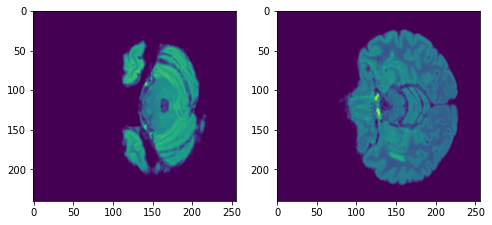

In [6]:
VOLUME_START_AT=260
VOLUME_SLICES=250

def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 10))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

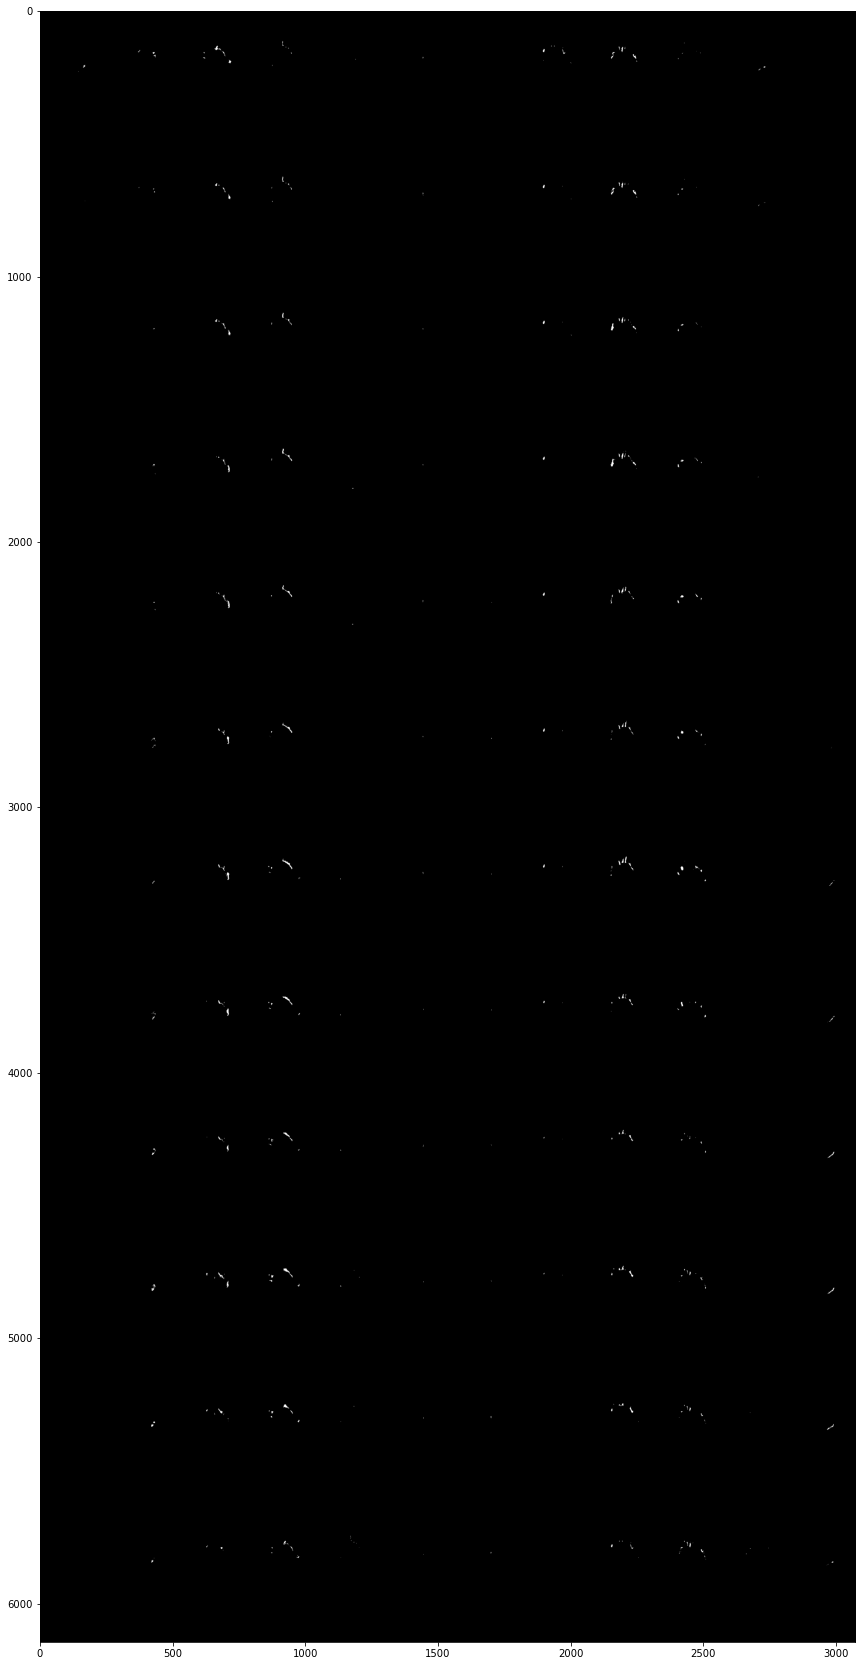

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,30))
ax1.imshow(rotate(montage(test_image_Brain_Mask[50:-50,:,:]), 90, resize=True), cmap ='gray')

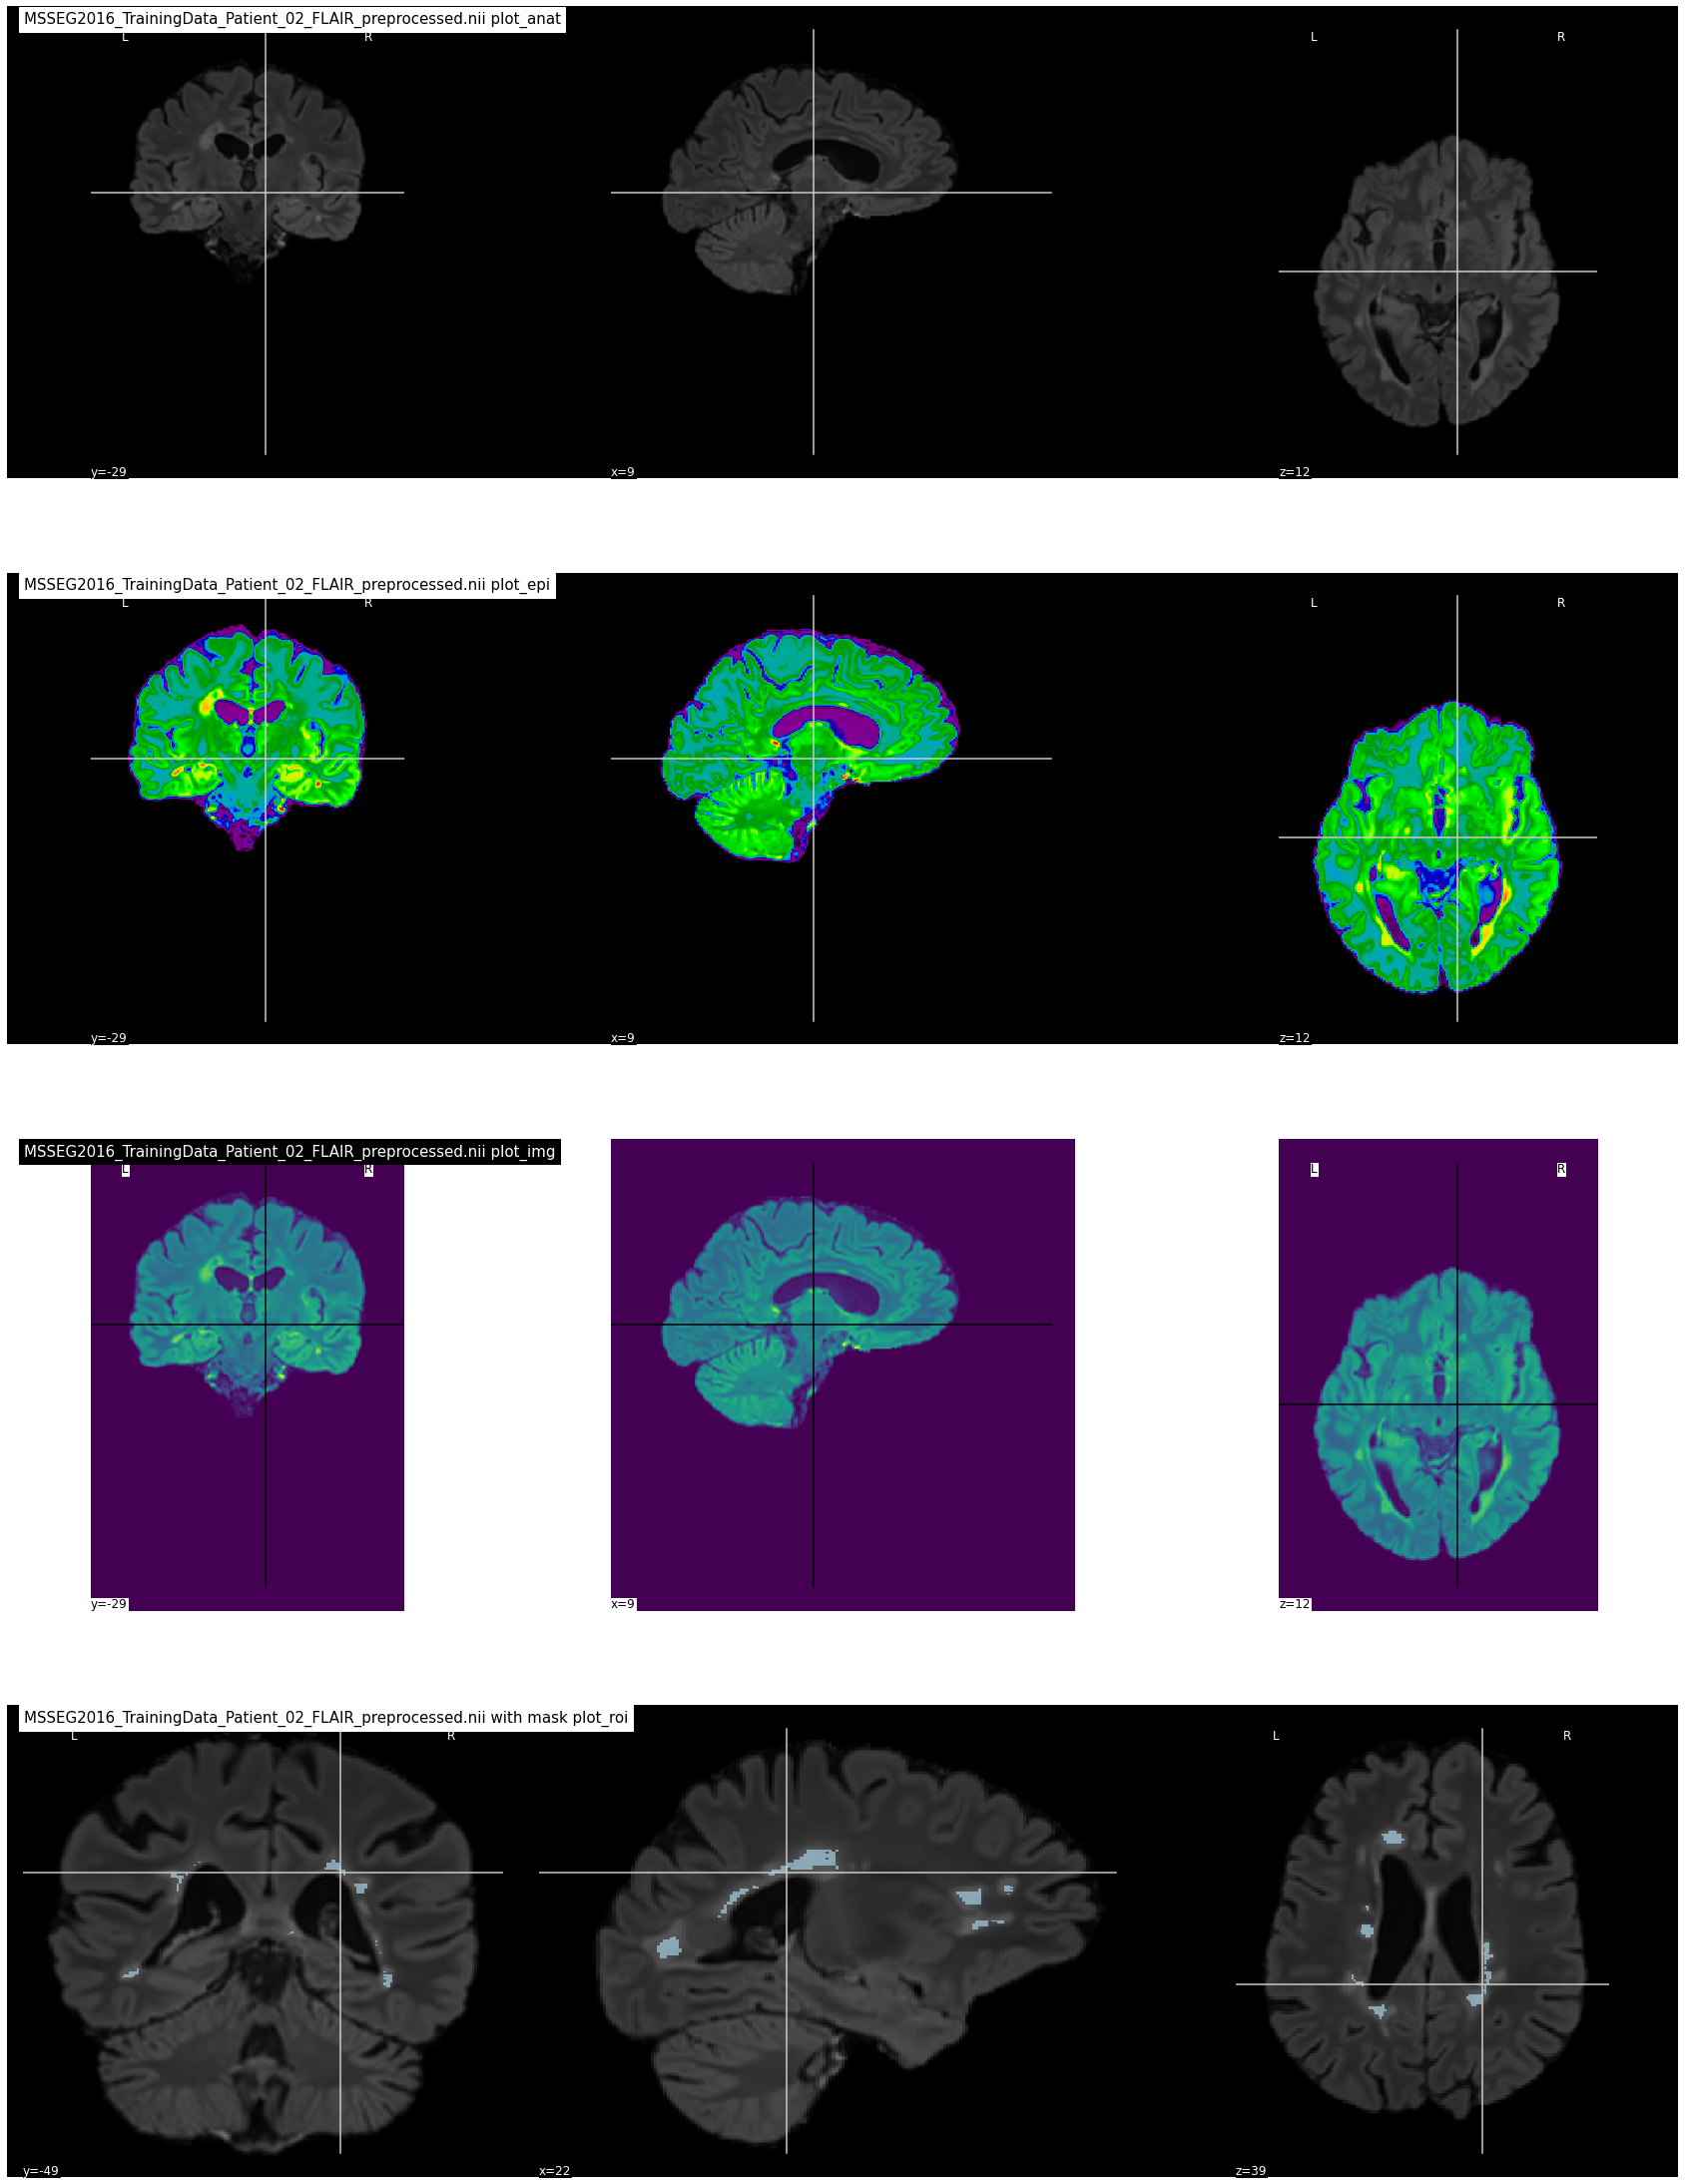

In [8]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_Consensus.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [9]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

def dice_coef_MS(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [10]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [11]:
IMG_SIZE=128

In [12]:
tf.keras.utils.Sequence

keras.utils.data_utils.Sequence

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size =1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
                
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 256))
        
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim,2))
        
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_FLAIR_preprocessed.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_DP_preprocessed.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_Consensus.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
            
        # Generate masks
        y[y==0] = 0;
        
        mask = tf.one_hot(y, 2);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
    

        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


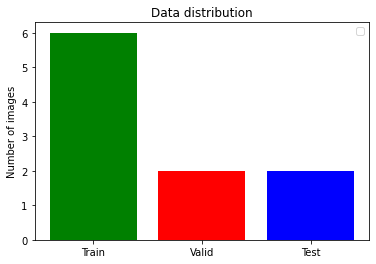

In [14]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [15]:
BACKBONE = 'resnet50'

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 2 
activation = 'softmax'

#create model
model_resnet = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True, input_shape = (128,128,2))


# compile keras model with defined optimozer, loss and metrics
model_resnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,precision, sensitivity, specificity] )

In [16]:
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 2)  6           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 2)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   6272        ['zero_padding2d[0][0]']   

 stage1_unit3_bn1 (BatchNormali  (None, 32, 32, 256)  1024       ['add_1[0][0]']                  
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, 32, 32, 256)  0          ['stage1_unit3_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 32, 32, 64)   16384       ['stage1_unit3_relu1[0][0]']     
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 32, 32, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
          

                                                                                                  
 stage2_unit2_relu3 (Activation  (None, 16, 16, 128)  0          ['stage2_unit2_bn3[0][0]']       
 )                                                                                                
                                                                                                  
 stage2_unit2_conv3 (Conv2D)    (None, 16, 16, 512)  65536       ['stage2_unit2_relu3[0][0]']     
                                                                                                  
 add_4 (Add)                    (None, 16, 16, 512)  0           ['stage2_unit2_conv3[0][0]',     
                                                                  'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, 16, 16, 512)  2048       ['add_4[0][0]']                  
 zation)  

 zero_padding2d_9 (ZeroPadding2  (None, 18, 18, 256)  0          ['stage3_unit1_relu2[0][0]']     
 D)                                                                                               
                                                                                                  
 stage3_unit1_conv2 (Conv2D)    (None, 8, 8, 256)    589824      ['zero_padding2d_9[0][0]']       
                                                                                                  
 stage3_unit1_bn3 (BatchNormali  (None, 8, 8, 256)   1024        ['stage3_unit1_conv2[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage3_unit1_relu3 (Activation  (None, 8, 8, 256)   0           ['stage3_unit1_bn3[0][0]']       
 )                                                                                                
          

                                                                                                  
 stage3_unit4_conv1 (Conv2D)    (None, 8, 8, 256)    262144      ['stage3_unit4_relu1[0][0]']     
                                                                                                  
 stage3_unit4_bn2 (BatchNormali  (None, 8, 8, 256)   1024        ['stage3_unit4_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage3_unit4_relu2 (Activation  (None, 8, 8, 256)   0           ['stage3_unit4_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 10, 10, 256)  0          ['stage3_unit4_relu2[0][0]']     
 2D)      

                                                                  'add_11[0][0]']                 
                                                                                                  
 stage4_unit1_bn1 (BatchNormali  (None, 8, 8, 1024)  4096        ['add_12[0][0]']                 
 zation)                                                                                          
                                                                                                  
 stage4_unit1_relu1 (Activation  (None, 8, 8, 1024)  0           ['stage4_unit1_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 stage4_unit1_conv1 (Conv2D)    (None, 8, 8, 512)    524288      ['stage4_unit1_relu1[0][0]']     
                                                                                                  
 stage4_un

 stage4_unit3_bn3 (BatchNormali  (None, 4, 4, 512)   2048        ['stage4_unit3_conv2[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu3 (Activation  (None, 4, 4, 512)   0           ['stage4_unit3_bn3[0][0]']       
 )                                                                                                
                                                                                                  
 stage4_unit3_conv3 (Conv2D)    (None, 4, 4, 2048)   1048576     ['stage4_unit3_relu3[0][0]']     
                                                                                                  
 add_15 (Add)                   (None, 4, 4, 2048)   0           ['stage4_unit3_conv3[0][0]',     
                                                                  'add_14[0][0]']                 
          

                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 64, 64, 64)  0           ['decoder_stage2b_relu[0][0]']   
 ampling2D)                                                                                       
                                                                                                  
 decoder_stage3_concat (Concate  (None, 64, 64, 128)  0          ['decoder_stage3_upsampling[0][0]
 nate)                                                           ',                               
                                                                  'relu0[0][0]']                  
                                                                                                  
 decoder_stage3a_conv (Conv2D)  (None, 64, 64, 32)   36864       ['decoder_stage3_concat[0][0]']  
                                                                                                  
 decoder_s

In [21]:
import pandas as pd


model = keras.models.load_model(r'E:/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

history = pd.read_csv('E:/resnet/imagenet_class_index.csv')



ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000001FCDE763490>.

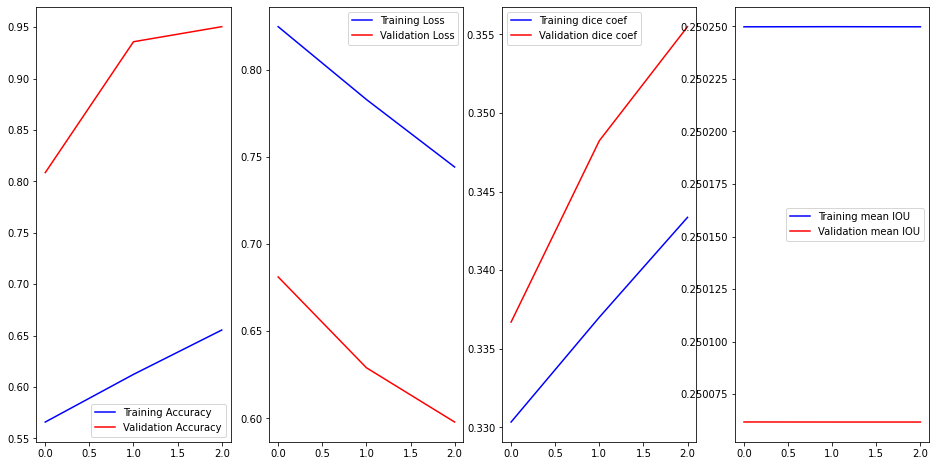

In [18]:
hist=history



acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_3'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_3'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [19]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
resnet = model.evaluate(test_generator)
print("test loss, test acc:", resnet)

Evaluate on test data


2022-07-30 06:21:52.413073: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2/2 [==============================] - 29s 11s/step - loss: 0.6008 - accuracy: 0.9472 - mean_io_u_2: 0.2500 - dice_coef: 0.3546 - dice_coef_MS: 4.1021e-04 - precision: 0.9471 - sensitivity: 0.9471 - specificity: 0.9471
test loss, test acc: [0.6008185744285583, 0.9471902847290039, 0.2500249743461609, 0.3545997440814972, 0.0004102093225810677, 0.9471238851547241, 0.9471495151519775, 0.9471495151519775]
